In [ ]:
# Copyright 2021 Radiotherapy AI Holdings Pty Ltd

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#    http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
import pathlib
import random
import shutil
import urllib.request

import imageio
import matplotlib.pyplot as plt
import tensorflow as tf

tf.random.set_seed(42)

In [3]:
zip_url = "https://github.com/RadiotherapyAI/unet-workshop/releases/download/mini-parotid/mini-parotid.zip"
zip_filepath = "data.zip"

data_directory = pathlib.Path("data")

if not data_directory.exists():
    urllib.request.urlretrieve(zip_url, zip_filepath)
    shutil.unpack_archive(zip_filepath, data_directory)

In [ ]:
dataset_types = [path.name for path in data_directory.glob("*") if path.is_dir()]
dataset_types

['hold-out', 'training', 'validation']

In [ ]:
def get_path_pairs(dataset_type):
    training_image_paths = list((data_directory / dataset_type).glob("*/*.image.png"))
    training_mask_paths = [
        path.parent / f"{path.name.split('.')[0]}.masks.png"
        for path in training_image_paths
    ]

    path_pairs = [
        (str(image), str(mask))
        for image, mask in zip(training_image_paths, training_mask_paths)
    ]

    return sorted(path_pairs)

In [ ]:
training_path_pairs = get_path_pairs("training")
training_path_pairs[0:5]

[('data/training/102315317145618078953192918760/0084.image.png',
  'data/training/102315317145618078953192918760/0084.masks.png'),
 ('data/training/102315317145618078953192918760/0085.image.png',
  'data/training/102315317145618078953192918760/0085.masks.png'),
 ('data/training/102315317145618078953192918760/0086.image.png',
  'data/training/102315317145618078953192918760/0086.masks.png'),
 ('data/training/102315317145618078953192918760/0087.image.png',
  'data/training/102315317145618078953192918760/0087.masks.png'),
 ('data/training/102315317145618078953192918760/0088.image.png',
  'data/training/102315317145618078953192918760/0088.masks.png')]

In [ ]:
training_dataset = tf.data.Dataset.from_tensor_slices(training_path_pairs)
training_dataset = training_dataset.shuffle(
    len(training_path_pairs), reshuffle_each_iteration=True
)

In [ ]:
validation_path_pairs = get_path_pairs("validation")
validation_dataset = tf.data.Dataset.from_tensor_slices(validation_path_pairs)
validation_dataset = validation_dataset.shuffle(
    len(validation_path_pairs), reshuffle_each_iteration=True
)

In [ ]:
@tf.function
def load(path_pair):
    image_raw = tf.io.read_file(path_pair[0])
    image = tf.io.decode_image(image_raw, channels=1, dtype=tf.uint8)

    masks_raw = tf.io.read_file(path_pair[1])
    masks = tf.io.decode_image(masks_raw, channels=3, dtype=tf.uint8)

    return image / 255, masks / 255

In [ ]:
training_dataset = training_dataset.map(load)
validation_dataset = validation_dataset.map(load)

In [ ]:
image, masks = iter(validation_dataset.take(1)).next()

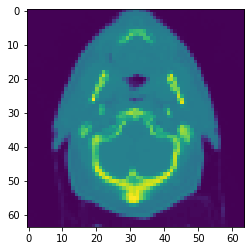

In [ ]:
plt.imshow(image)

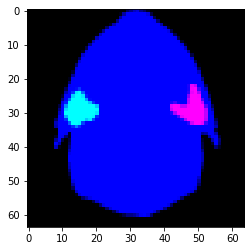

In [ ]:
plt.imshow(masks)

In [ ]:
colours_and_labels = [
    ("#ff7f0e", "left parotid"),
    ("#2ca02c", "right parotid"),
    ("#d62728", "external"),
]

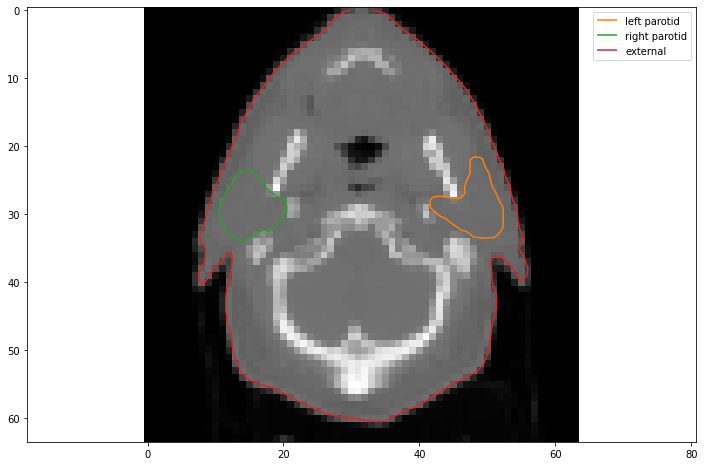

In [ ]:
plt.figure(figsize=(12, 8))
plt.imshow(image, cmap="gray")

for i, (colour, label) in enumerate(colours_and_labels):
    c = plt.contour(masks[..., i], colors=[colour], levels=[0.5])
    c.collections[0].set_label(label)

plt.axis("equal")
plt.legend()

In [ ]:
def activation(x):
    x = tf.keras.layers.Activation("relu")(x)

    return x


def convolution(x, number_of_filters, kernel_size=3):
    x = tf.keras.layers.Conv2D(
        number_of_filters, kernel_size, padding="same", kernel_initializer="he_normal"
    )(x)

    return x


def conv_transpose(x, number_of_filters, kernel_size=3):
    x = tf.keras.layers.Conv2DTranspose(
        number_of_filters,
        kernel_size,
        strides=2,
        padding="same",
        kernel_initializer="he_normal",
    )(x)

    return x

In [ ]:
def encode(
    x,
    number_of_filters,
    number_of_convolutions=2,
):
    for _ in range(number_of_convolutions):
        x = convolution(x, number_of_filters)
        x = activation(x)
    skip = x

    x = tf.keras.layers.MaxPool2D()(x)
    x = activation(x)

    return x, skip


def decode(
    x,
    skip,
    number_of_filters,
    number_of_convolutions=2,
):
    x = conv_transpose(x, number_of_filters)
    x = activation(x)

    x = tf.keras.layers.concatenate([skip, x], axis=3)

    for _ in range(number_of_convolutions):
        x = convolution(x, number_of_filters)
        x = activation(x)

    return x

In [ ]:
GRID_SIZE = 64
NUM_CONTOURS = 3

In [ ]:
inputs = tf.keras.layers.Input((GRID_SIZE, GRID_SIZE, 1))

x = inputs
skips = []

for number_of_filters in [32, 64, 128]:
    x, skip = encode(x, number_of_filters)
    skips.append(skip)

skips.reverse()

for number_of_filters, skip in zip([256, 128, 64], skips):
    x = decode(x, skip, number_of_filters)

x = tf.keras.layers.Conv2D(
    NUM_CONTOURS,
    1,
    activation="sigmoid",
    padding="same",
    kernel_initializer="he_normal",
)(x)

model = tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   9248        activation[0][0]                 
______________________________________________________________________________________________

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
    ],
)

In [ ]:
image.shape

TensorShape([64, 64, 1])

In [ ]:
pred_masks = model.predict(image[None, ...])[0, ...]

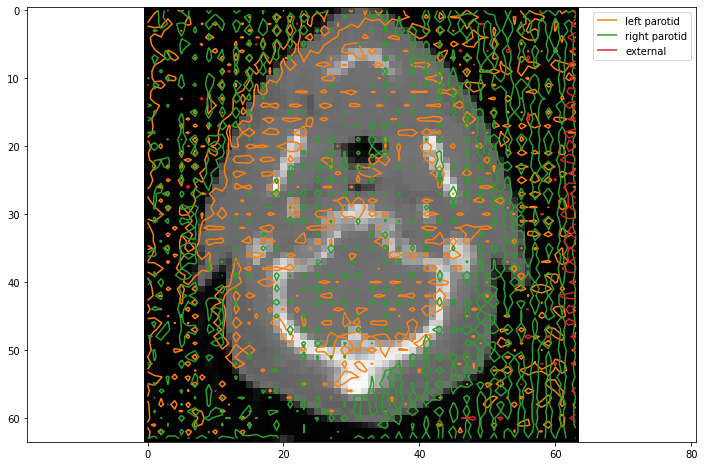

In [ ]:
plt.figure(figsize=(12, 8))
plt.imshow(image, cmap="gray")

for i, (colour, label) in enumerate(colours_and_labels):
    c = plt.contour(pred_masks[..., i], colors=[colour], levels=[0.5])
    c.collections[0].set_label(label)

plt.axis("equal")
plt.legend()

In [ ]:
def plot_contours(ax, image, masks):
    ax.imshow(image, cmap="gray")

    for i, (colour, label) in enumerate(colours_and_labels):
        c = ax.contour(masks[..., i], colors=[colour], levels=[0.5])
        c.collections[0].set_label(label)

    ax.axis("equal")
    ax.legend()

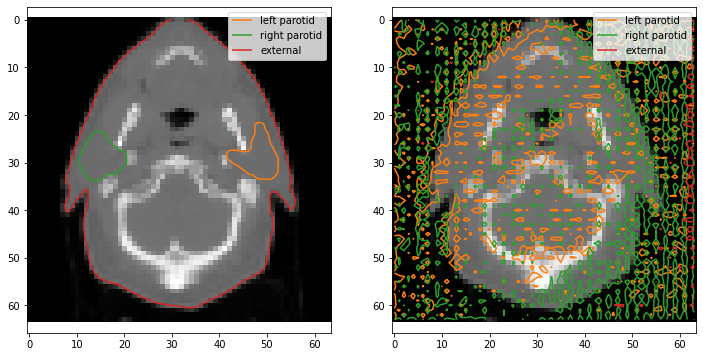

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
plot_contours(ax[0], image, masks)
plot_contours(ax[1], image, pred_masks)

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
        plot_contours(ax[0], image, masks)

        pred_masks = model.predict(image[None, ...])[0, ...]
        plot_contours(ax[1], image, pred_masks)

        plt.show()
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

In [ ]:
BATCH_SIZE = 512

batched_training_dataset = training_dataset.batch(BATCH_SIZE)
batched_training_dataset = batched_training_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
batched_validation_dataset = validation_dataset.batch(BATCH_SIZE)
batched_validation_dataset = batched_validation_dataset.prefetch(tf.data.AUTOTUNE)

Epoch 1/50
4/4 [==============================] - 13s 2s/step - loss: 0.6726 - binary_accuracy: 0.7112 - recall: 0.0131 - precision: 0.0128 - val_loss: 0.4980 - val_binary_accuracy: 0.9145 - val_recall: 0.6474 - val_precision: 0.7615


<ipython-input-25-1e56f68d2885>:5: UserWarning: No contour levels were found within the data range.
  c = ax.contour(masks[..., i], colors=[colour], levels=[0.5])


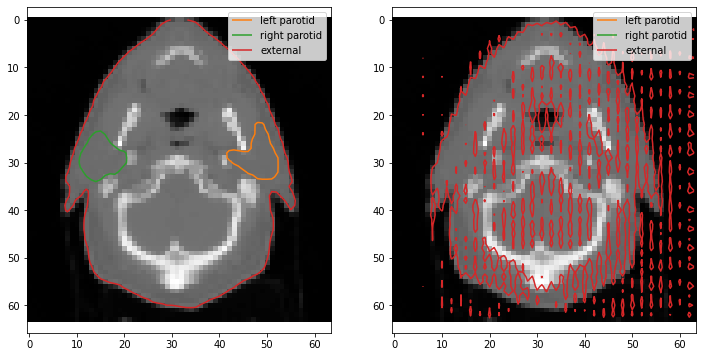


Sample Prediction after epoch 1

Epoch 2/50
4/4 [==============================] - 1s 250ms/step - loss: 0.3878 - binary_accuracy: 0.8678 - recall: 0.8543 - precision: 0.5519 - val_loss: 0.2898 - val_binary_accuracy: 0.8905 - val_recall: 0.2471 - val_precision: 0.9910


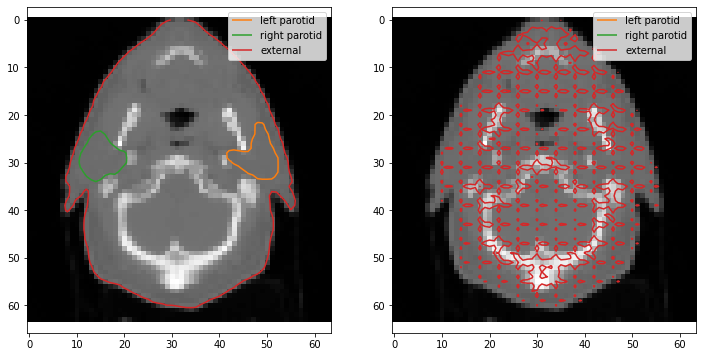


Sample Prediction after epoch 2

Epoch 3/50
4/4 [==============================] - 1s 250ms/step - loss: 0.2442 - binary_accuracy: 0.9269 - recall: 0.6717 - precision: 0.8422 - val_loss: 0.1550 - val_binary_accuracy: 0.9718 - val_recall: 0.9049 - val_precision: 0.9598


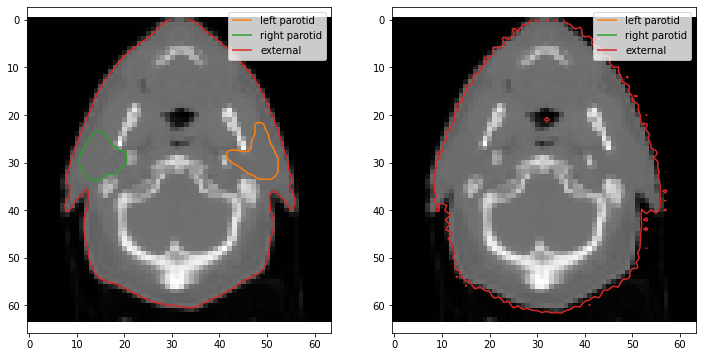


Sample Prediction after epoch 3

Epoch 4/50
4/4 [==============================] - 1s 249ms/step - loss: 0.1235 - binary_accuracy: 0.9696 - recall: 0.8362 - precision: 0.9848 - val_loss: 0.0700 - val_binary_accuracy: 0.9768 - val_recall: 0.9127 - val_precision: 0.9896


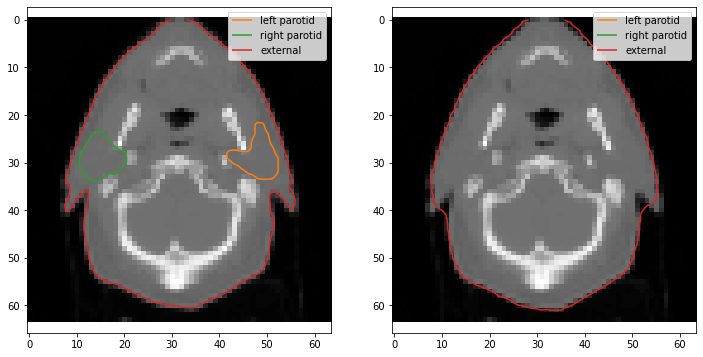


Sample Prediction after epoch 4

Epoch 5/50
4/4 [==============================] - 1s 242ms/step - loss: 0.0644 - binary_accuracy: 0.9749 - recall: 0.8900 - precision: 0.9908 - val_loss: 0.0522 - val_binary_accuracy: 0.9755 - val_recall: 0.9331 - val_precision: 0.9754


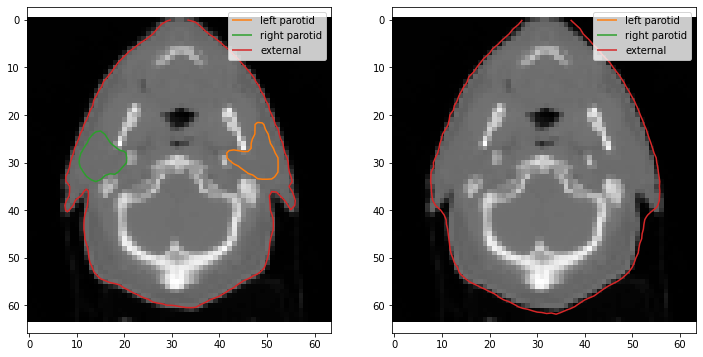


Sample Prediction after epoch 5

Epoch 6/50
4/4 [==============================] - 1s 242ms/step - loss: 0.0504 - binary_accuracy: 0.9756 - recall: 0.9046 - precision: 0.9845 - val_loss: 0.0435 - val_binary_accuracy: 0.9769 - val_recall: 0.9225 - val_precision: 0.9849


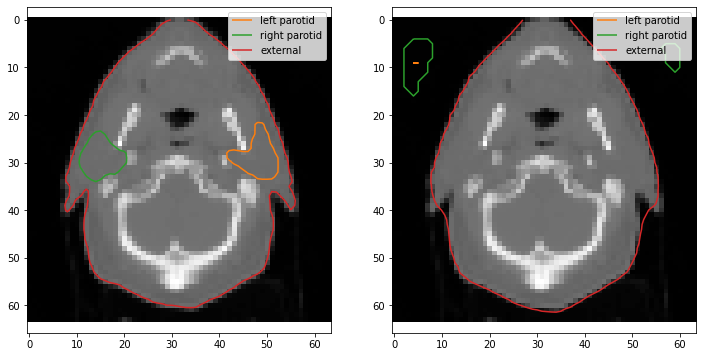


Sample Prediction after epoch 6

Epoch 7/50
4/4 [==============================] - 1s 242ms/step - loss: 0.0445 - binary_accuracy: 0.9765 - recall: 0.9121 - precision: 0.9882 - val_loss: 0.0423 - val_binary_accuracy: 0.9774 - val_recall: 0.9185 - val_precision: 0.9888


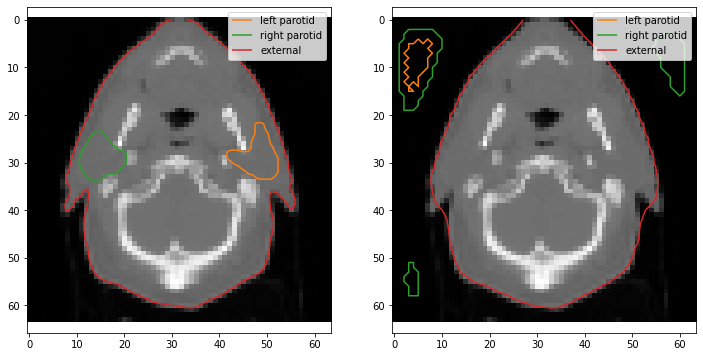


Sample Prediction after epoch 7

Epoch 8/50
4/4 [==============================] - 1s 248ms/step - loss: 0.0421 - binary_accuracy: 0.9772 - recall: 0.9070 - precision: 0.9917 - val_loss: 0.0408 - val_binary_accuracy: 0.9777 - val_recall: 0.9069 - val_precision: 0.9915


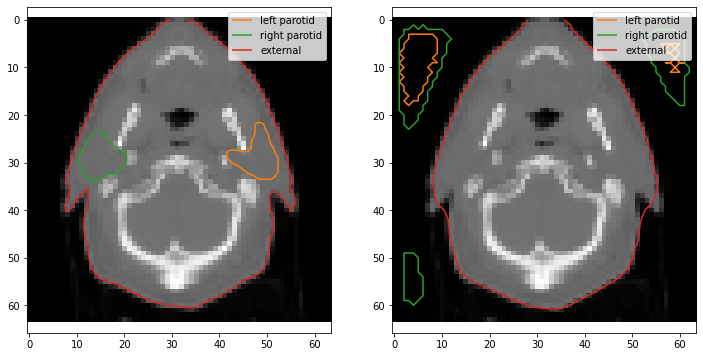


Sample Prediction after epoch 8

Epoch 9/50
4/4 [==============================] - 1s 249ms/step - loss: 0.0405 - binary_accuracy: 0.9774 - recall: 0.9085 - precision: 0.9927 - val_loss: 0.0405 - val_binary_accuracy: 0.9778 - val_recall: 0.8992 - val_precision: 0.9942


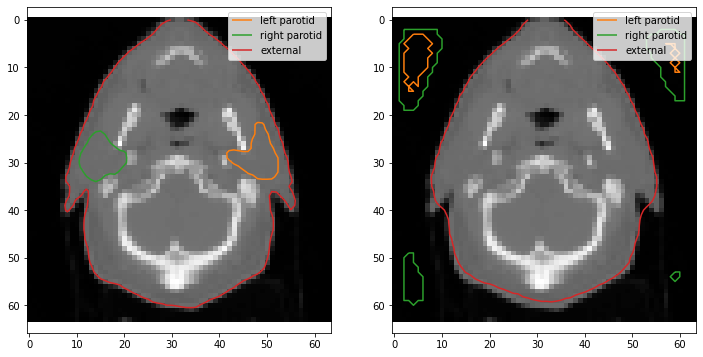


Sample Prediction after epoch 9

Epoch 10/50
4/4 [==============================] - 1s 249ms/step - loss: 0.0400 - binary_accuracy: 0.9774 - recall: 0.9051 - precision: 0.9939 - val_loss: 0.0389 - val_binary_accuracy: 0.9780 - val_recall: 0.8993 - val_precision: 0.9940


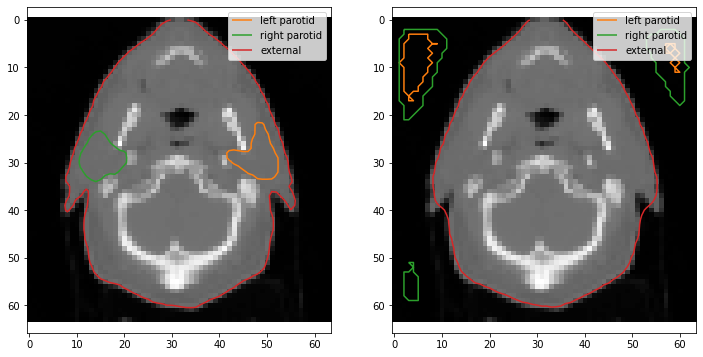


Sample Prediction after epoch 10

Epoch 11/50
4/4 [==============================] - 1s 248ms/step - loss: 0.0387 - binary_accuracy: 0.9776 - recall: 0.8979 - precision: 0.9948 - val_loss: 0.0379 - val_binary_accuracy: 0.9779 - val_recall: 0.9096 - val_precision: 0.9929


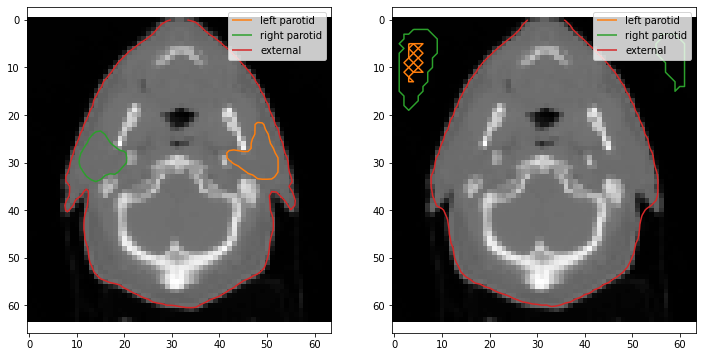


Sample Prediction after epoch 11

Epoch 12/50
4/4 [==============================] - 1s 245ms/step - loss: 0.0376 - binary_accuracy: 0.9776 - recall: 0.9005 - precision: 0.9950 - val_loss: 0.0368 - val_binary_accuracy: 0.9780 - val_recall: 0.9072 - val_precision: 0.9937


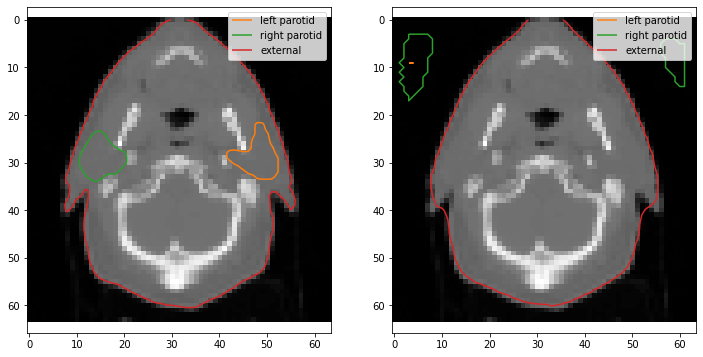


Sample Prediction after epoch 12

Epoch 13/50
4/4 [==============================] - 1s 249ms/step - loss: 0.0364 - binary_accuracy: 0.9777 - recall: 0.9019 - precision: 0.9950 - val_loss: 0.0355 - val_binary_accuracy: 0.9782 - val_recall: 0.9011 - val_precision: 0.9947


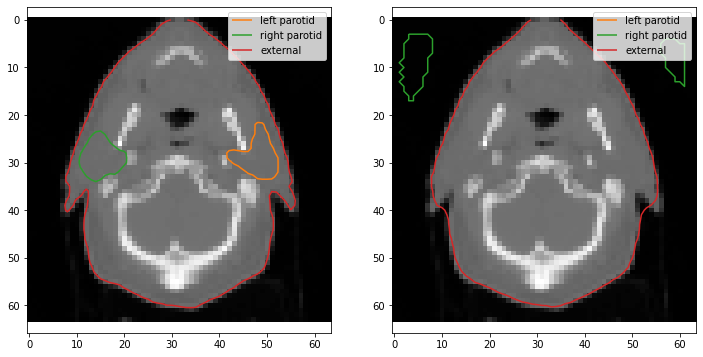


Sample Prediction after epoch 13

Epoch 14/50
4/4 [==============================] - 1s 248ms/step - loss: 0.0351 - binary_accuracy: 0.9777 - recall: 0.9012 - precision: 0.9953 - val_loss: 0.0339 - val_binary_accuracy: 0.9783 - val_recall: 0.8966 - val_precision: 0.9956


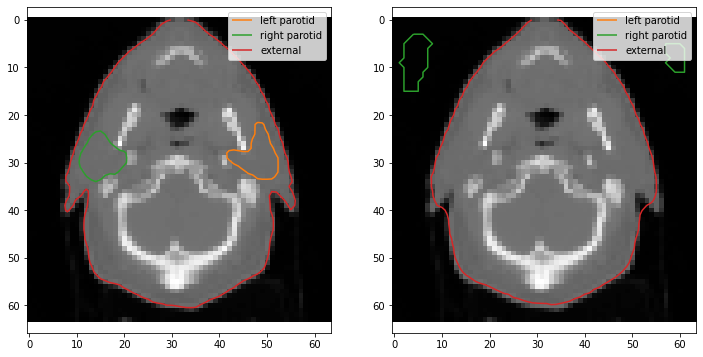


Sample Prediction after epoch 14

Epoch 15/50
4/4 [==============================] - 1s 253ms/step - loss: 0.0334 - binary_accuracy: 0.9779 - recall: 0.9003 - precision: 0.9959 - val_loss: 0.0323 - val_binary_accuracy: 0.9784 - val_recall: 0.8978 - val_precision: 0.9958


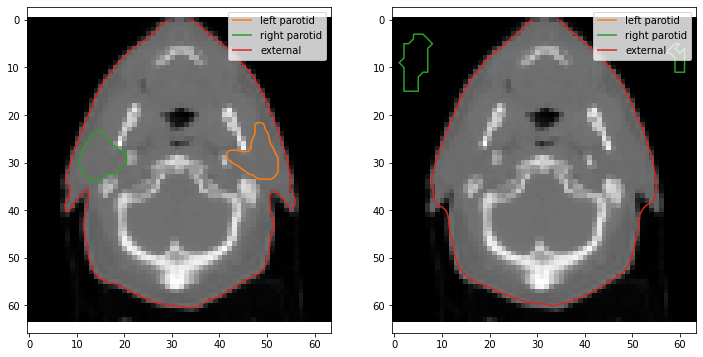


Sample Prediction after epoch 15

Epoch 16/50
4/4 [==============================] - 1s 251ms/step - loss: 0.0318 - binary_accuracy: 0.9780 - recall: 0.8994 - precision: 0.9962 - val_loss: 0.0307 - val_binary_accuracy: 0.9786 - val_recall: 0.9011 - val_precision: 0.9957


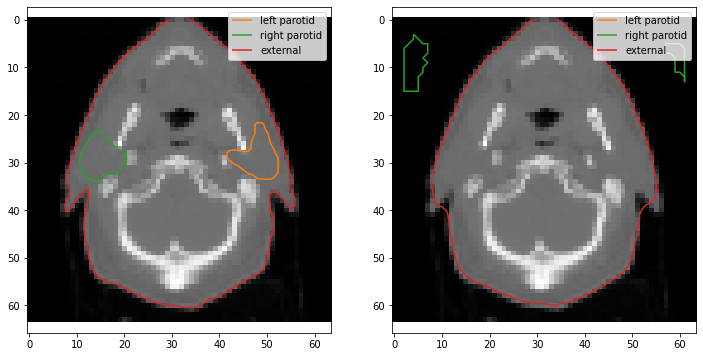


Sample Prediction after epoch 16

Epoch 17/50
4/4 [==============================] - 1s 250ms/step - loss: 0.0301 - binary_accuracy: 0.9782 - recall: 0.9011 - precision: 0.9964 - val_loss: 0.0291 - val_binary_accuracy: 0.9787 - val_recall: 0.9030 - val_precision: 0.9958


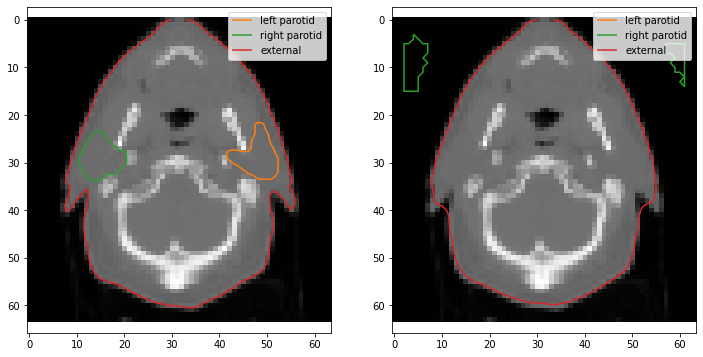


Sample Prediction after epoch 17

Epoch 18/50
4/4 [==============================] - 1s 256ms/step - loss: 0.0285 - binary_accuracy: 0.9783 - recall: 0.9022 - precision: 0.9965 - val_loss: 0.0281 - val_binary_accuracy: 0.9788 - val_recall: 0.8993 - val_precision: 0.9964


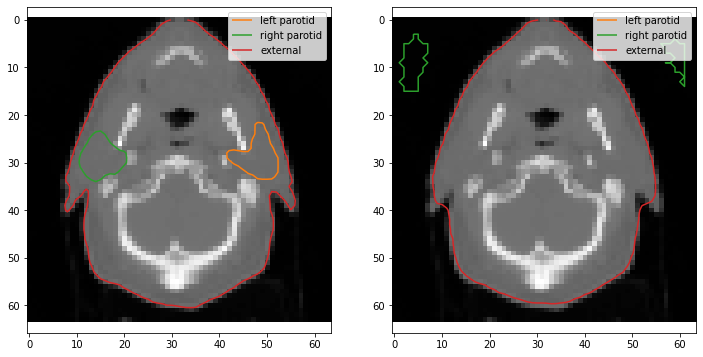


Sample Prediction after epoch 18

Epoch 19/50
4/4 [==============================] - 1s 252ms/step - loss: 0.0273 - binary_accuracy: 0.9783 - recall: 0.9010 - precision: 0.9968 - val_loss: 0.0278 - val_binary_accuracy: 0.9787 - val_recall: 0.9094 - val_precision: 0.9955


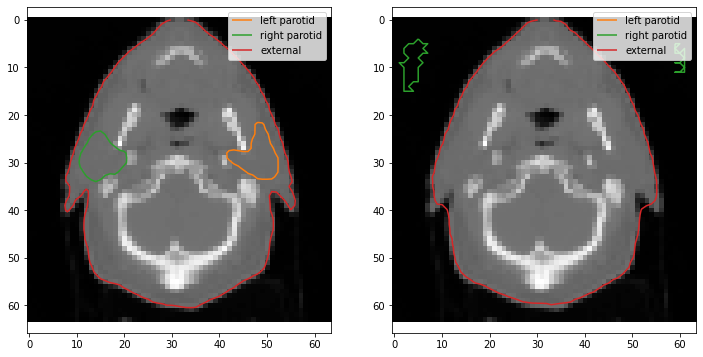


Sample Prediction after epoch 19

Epoch 20/50
4/4 [==============================] - 1s 251ms/step - loss: 0.0270 - binary_accuracy: 0.9784 - recall: 0.9015 - precision: 0.9970 - val_loss: 0.0268 - val_binary_accuracy: 0.9789 - val_recall: 0.8915 - val_precision: 0.9974


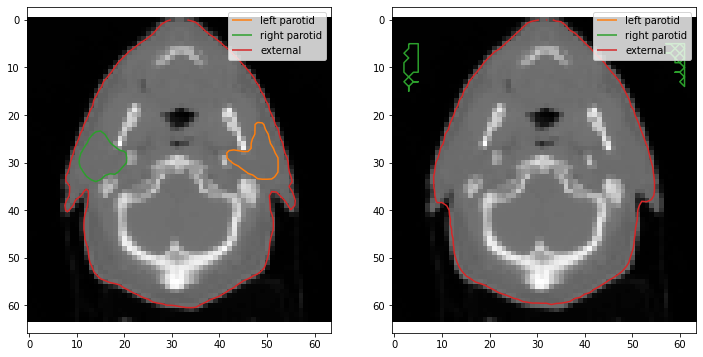


Sample Prediction after epoch 20

Epoch 21/50
4/4 [==============================] - 1s 251ms/step - loss: 0.0266 - binary_accuracy: 0.9784 - recall: 0.8994 - precision: 0.9973 - val_loss: 0.0257 - val_binary_accuracy: 0.9788 - val_recall: 0.9076 - val_precision: 0.9962


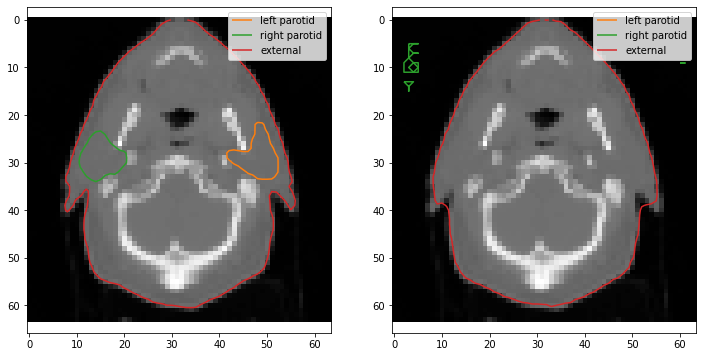


Sample Prediction after epoch 21

Epoch 22/50
4/4 [==============================] - 1s 249ms/step - loss: 0.0252 - binary_accuracy: 0.9784 - recall: 0.9015 - precision: 0.9973 - val_loss: 0.0255 - val_binary_accuracy: 0.9788 - val_recall: 0.9082 - val_precision: 0.9963


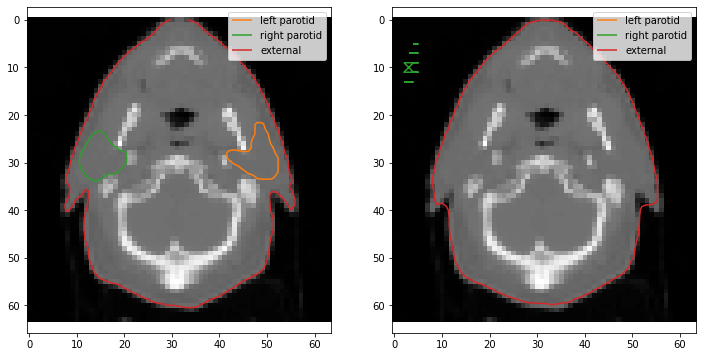


Sample Prediction after epoch 22

Epoch 23/50
4/4 [==============================] - 1s 252ms/step - loss: 0.0244 - binary_accuracy: 0.9784 - recall: 0.9020 - precision: 0.9974 - val_loss: 0.0240 - val_binary_accuracy: 0.9789 - val_recall: 0.8998 - val_precision: 0.9974


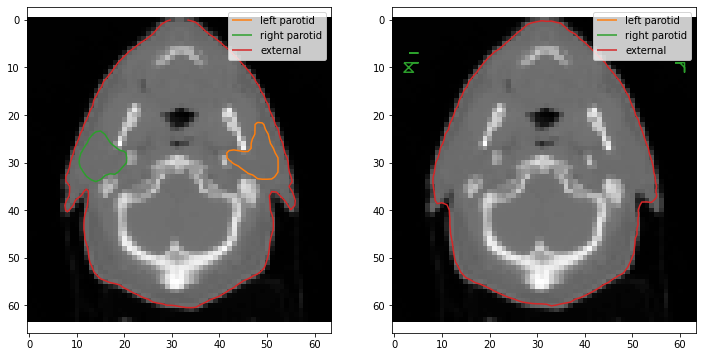


Sample Prediction after epoch 23

Epoch 24/50
4/4 [==============================] - 1s 252ms/step - loss: 0.0234 - binary_accuracy: 0.9785 - recall: 0.9008 - precision: 0.9977 - val_loss: 0.0232 - val_binary_accuracy: 0.9789 - val_recall: 0.9047 - val_precision: 0.9971


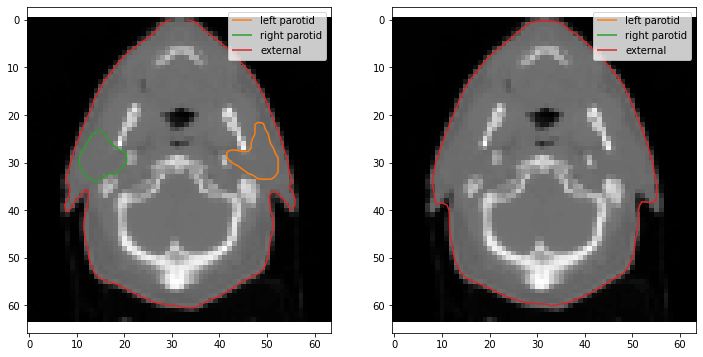


Sample Prediction after epoch 24

Epoch 25/50
4/4 [==============================] - 1s 251ms/step - loss: 0.0225 - binary_accuracy: 0.9785 - recall: 0.9000 - precision: 0.9978 - val_loss: 0.0225 - val_binary_accuracy: 0.9790 - val_recall: 0.9006 - val_precision: 0.9975


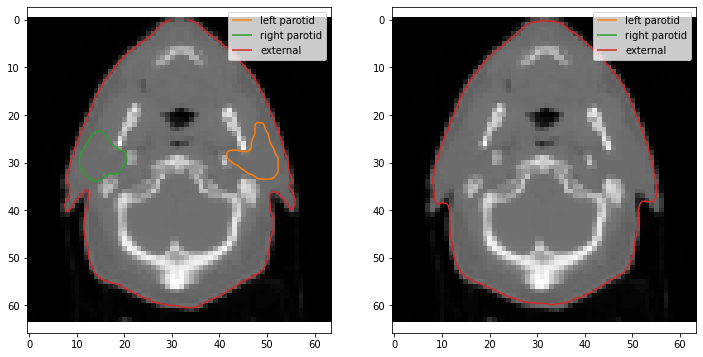


Sample Prediction after epoch 25

Epoch 26/50
4/4 [==============================] - 1s 249ms/step - loss: 0.0216 - binary_accuracy: 0.9786 - recall: 0.9008 - precision: 0.9979 - val_loss: 0.0217 - val_binary_accuracy: 0.9792 - val_recall: 0.9031 - val_precision: 0.9972


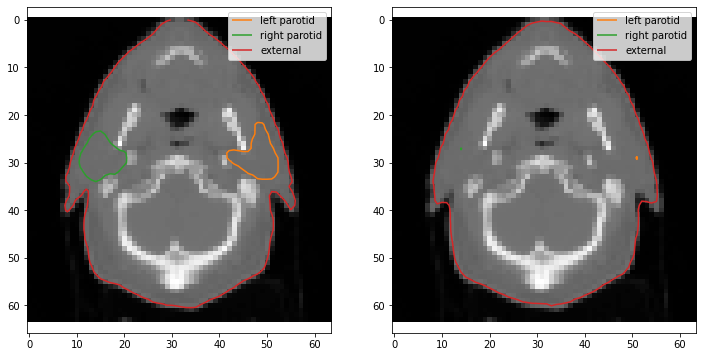


Sample Prediction after epoch 26

Epoch 27/50
4/4 [==============================] - 1s 250ms/step - loss: 0.0208 - binary_accuracy: 0.9790 - recall: 0.9052 - precision: 0.9972 - val_loss: 0.0209 - val_binary_accuracy: 0.9797 - val_recall: 0.9076 - val_precision: 0.9953


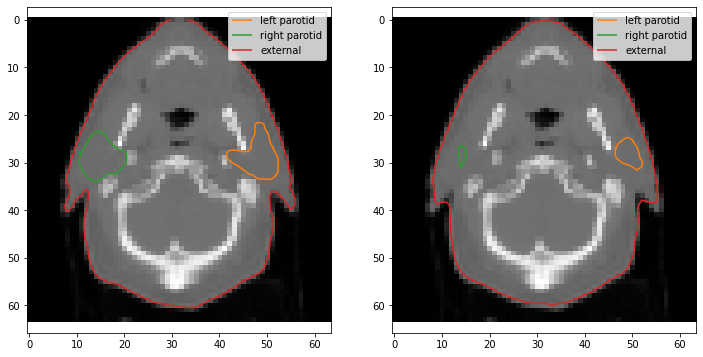


Sample Prediction after epoch 27

Epoch 28/50
4/4 [==============================] - 1s 252ms/step - loss: 0.0202 - binary_accuracy: 0.9796 - recall: 0.9130 - precision: 0.9953 - val_loss: 0.0234 - val_binary_accuracy: 0.9795 - val_recall: 0.8866 - val_precision: 0.9964


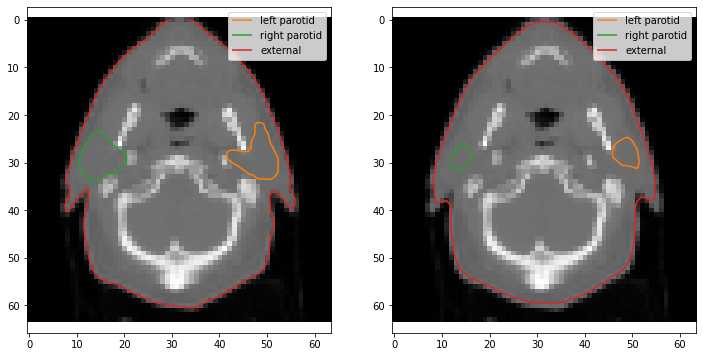


Sample Prediction after epoch 28

Epoch 29/50
4/4 [==============================] - 1s 252ms/step - loss: 0.0237 - binary_accuracy: 0.9792 - recall: 0.9149 - precision: 0.9909 - val_loss: 0.0263 - val_binary_accuracy: 0.9791 - val_recall: 0.9617 - val_precision: 0.9794


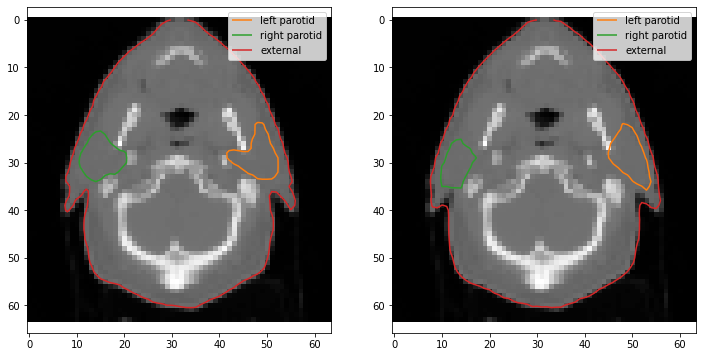


Sample Prediction after epoch 29

Epoch 30/50
4/4 [==============================] - 1s 253ms/step - loss: 0.0245 - binary_accuracy: 0.9790 - recall: 0.9303 - precision: 0.9888 - val_loss: 0.0207 - val_binary_accuracy: 0.9802 - val_recall: 0.9237 - val_precision: 0.9925


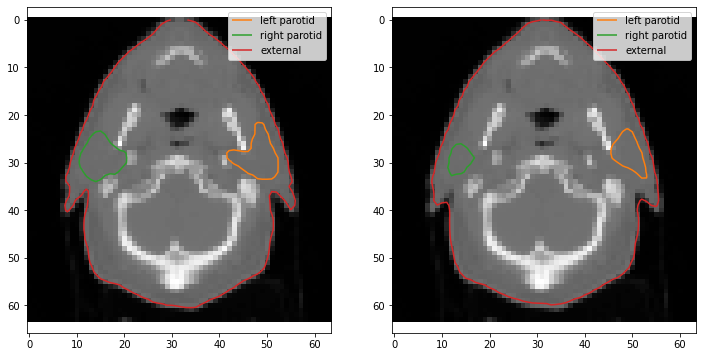


Sample Prediction after epoch 30

Epoch 31/50
4/4 [==============================] - 1s 253ms/step - loss: 0.0221 - binary_accuracy: 0.9796 - recall: 0.9316 - precision: 0.9928 - val_loss: 0.0236 - val_binary_accuracy: 0.9792 - val_recall: 0.8801 - val_precision: 0.9981


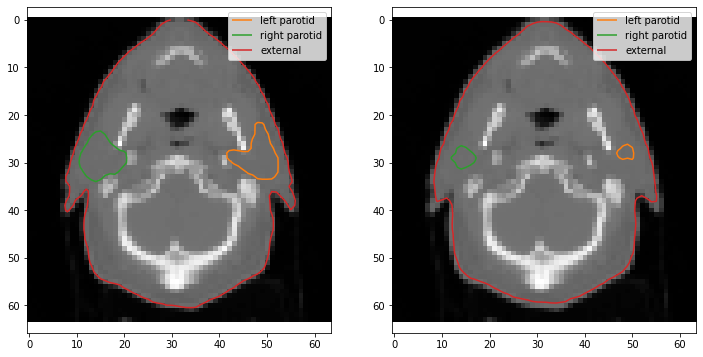


Sample Prediction after epoch 31

Epoch 32/50
4/4 [==============================] - 1s 245ms/step - loss: 0.0213 - binary_accuracy: 0.9796 - recall: 0.9149 - precision: 0.9944 - val_loss: 0.0200 - val_binary_accuracy: 0.9803 - val_recall: 0.9183 - val_precision: 0.9956


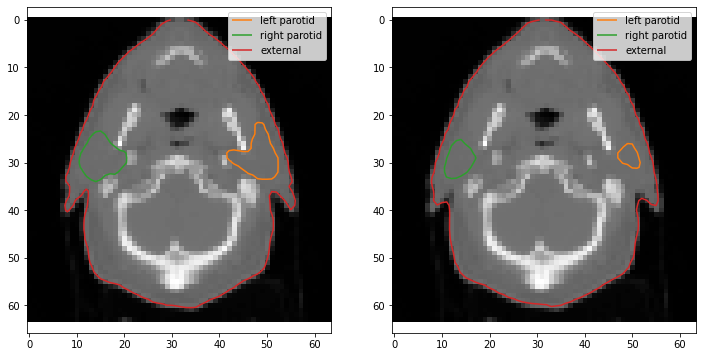


Sample Prediction after epoch 32

Epoch 33/50
4/4 [==============================] - 1s 250ms/step - loss: 0.0197 - binary_accuracy: 0.9800 - recall: 0.9136 - precision: 0.9934 - val_loss: 0.0212 - val_binary_accuracy: 0.9802 - val_recall: 0.9337 - val_precision: 0.9937


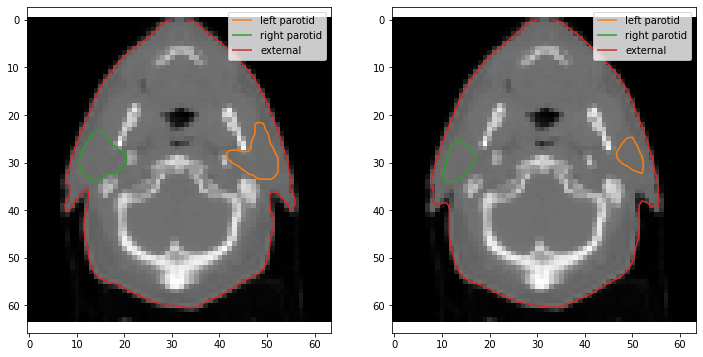


Sample Prediction after epoch 33

Epoch 34/50
4/4 [==============================] - 1s 250ms/step - loss: 0.0193 - binary_accuracy: 0.9801 - recall: 0.9253 - precision: 0.9926 - val_loss: 0.0191 - val_binary_accuracy: 0.9806 - val_recall: 0.9247 - val_precision: 0.9935


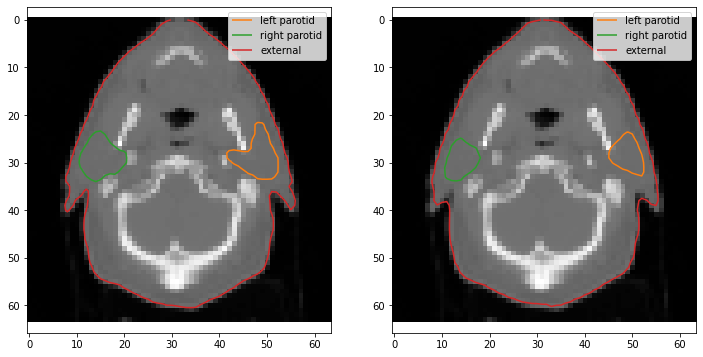


Sample Prediction after epoch 34

Epoch 35/50
4/4 [==============================] - 1s 253ms/step - loss: 0.0185 - binary_accuracy: 0.9803 - recall: 0.9311 - precision: 0.9927 - val_loss: 0.0196 - val_binary_accuracy: 0.9805 - val_recall: 0.9132 - val_precision: 0.9914


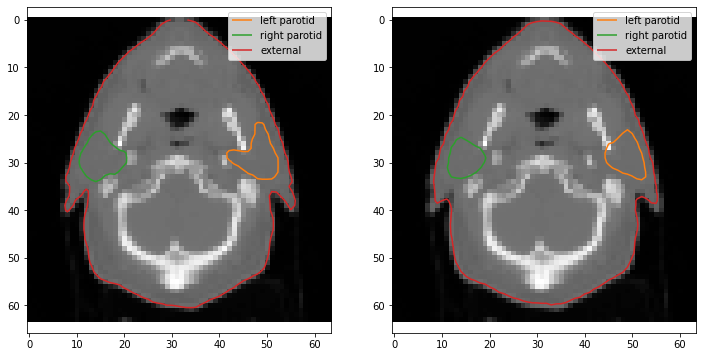


Sample Prediction after epoch 35

Epoch 36/50
4/4 [==============================] - 1s 251ms/step - loss: 0.0184 - binary_accuracy: 0.9803 - recall: 0.9242 - precision: 0.9929 - val_loss: 0.0186 - val_binary_accuracy: 0.9807 - val_recall: 0.9219 - val_precision: 0.9935


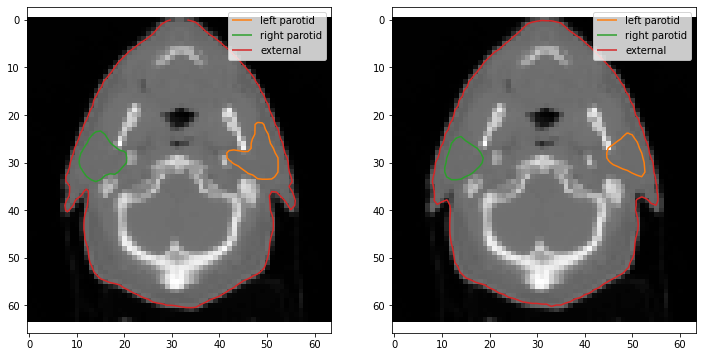


Sample Prediction after epoch 36

Epoch 37/50
4/4 [==============================] - 1s 253ms/step - loss: 0.0178 - binary_accuracy: 0.9805 - recall: 0.9210 - precision: 0.9936 - val_loss: 0.0191 - val_binary_accuracy: 0.9806 - val_recall: 0.9282 - val_precision: 0.9944


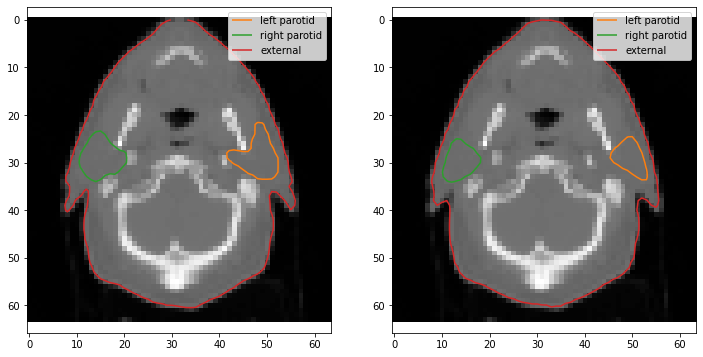


Sample Prediction after epoch 37

Epoch 38/50
4/4 [==============================] - 1s 250ms/step - loss: 0.0177 - binary_accuracy: 0.9805 - recall: 0.9246 - precision: 0.9935 - val_loss: 0.0183 - val_binary_accuracy: 0.9807 - val_recall: 0.9355 - val_precision: 0.9899


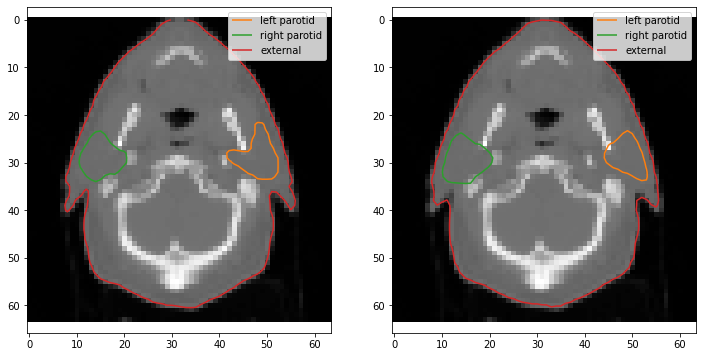


Sample Prediction after epoch 38

Epoch 39/50
4/4 [==============================] - 1s 252ms/step - loss: 0.0175 - binary_accuracy: 0.9805 - recall: 0.9309 - precision: 0.9926 - val_loss: 0.0182 - val_binary_accuracy: 0.9809 - val_recall: 0.9189 - val_precision: 0.9944


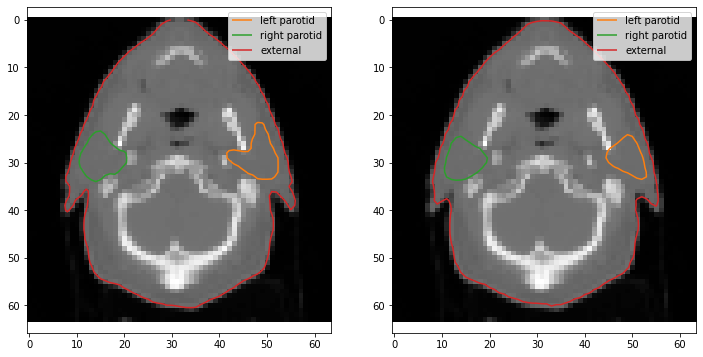


Sample Prediction after epoch 39

Epoch 40/50
4/4 [==============================] - 1s 250ms/step - loss: 0.0172 - binary_accuracy: 0.9806 - recall: 0.9284 - precision: 0.9932 - val_loss: 0.0181 - val_binary_accuracy: 0.9809 - val_recall: 0.9195 - val_precision: 0.9938


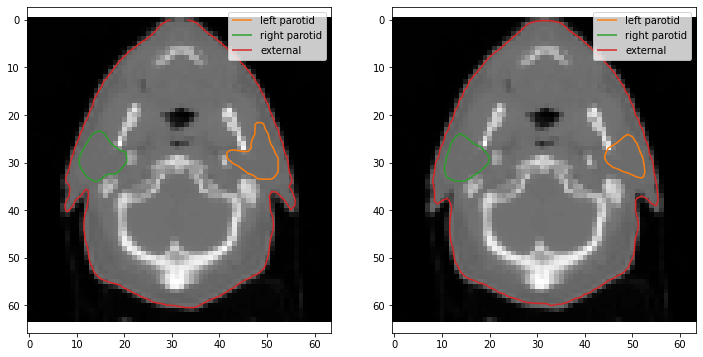


Sample Prediction after epoch 40

Epoch 41/50
4/4 [==============================] - 1s 252ms/step - loss: 0.0171 - binary_accuracy: 0.9807 - recall: 0.9266 - precision: 0.9933 - val_loss: 0.0177 - val_binary_accuracy: 0.9809 - val_recall: 0.9283 - val_precision: 0.9918


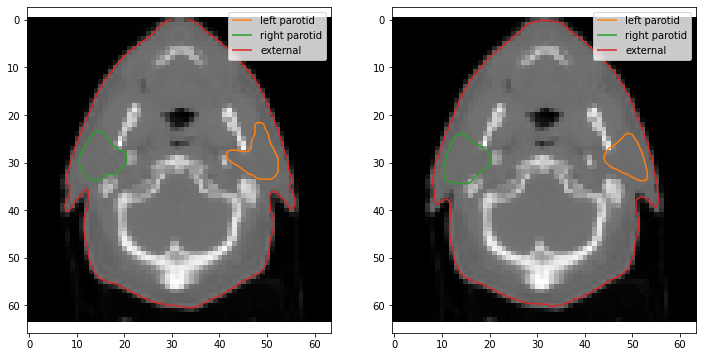


Sample Prediction after epoch 41

Epoch 42/50
4/4 [==============================] - 1s 252ms/step - loss: 0.0170 - binary_accuracy: 0.9806 - recall: 0.9258 - precision: 0.9930 - val_loss: 0.0180 - val_binary_accuracy: 0.9807 - val_recall: 0.9383 - val_precision: 0.9885


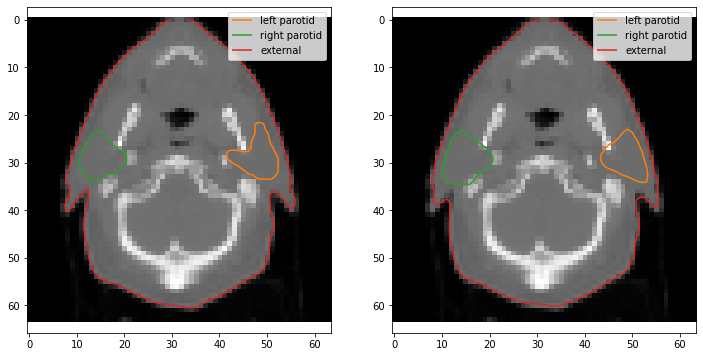


Sample Prediction after epoch 42

Epoch 43/50
4/4 [==============================] - 1s 249ms/step - loss: 0.0177 - binary_accuracy: 0.9802 - recall: 0.9283 - precision: 0.9903 - val_loss: 0.0175 - val_binary_accuracy: 0.9810 - val_recall: 0.9325 - val_precision: 0.9918


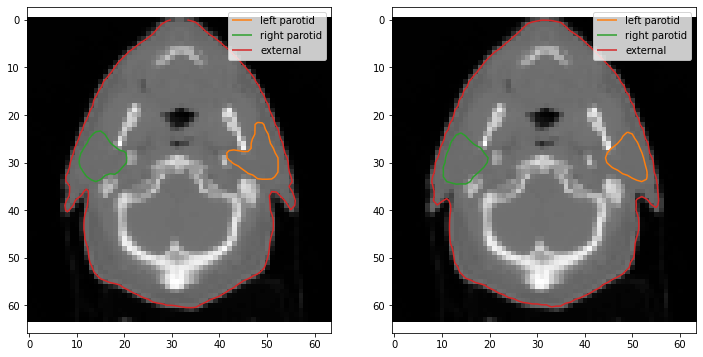


Sample Prediction after epoch 43

Epoch 44/50
4/4 [==============================] - 1s 250ms/step - loss: 0.0170 - binary_accuracy: 0.9806 - recall: 0.9289 - precision: 0.9925 - val_loss: 0.0175 - val_binary_accuracy: 0.9809 - val_recall: 0.9341 - val_precision: 0.9901


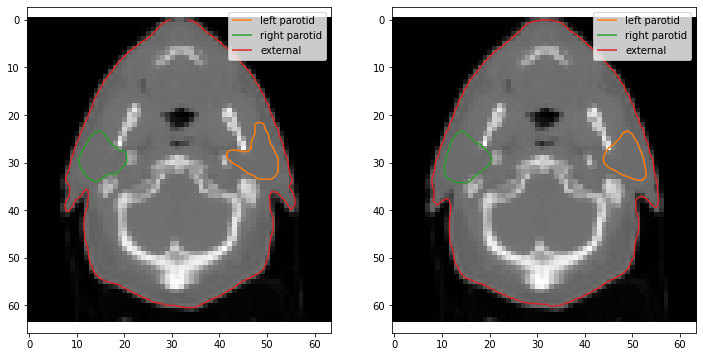


Sample Prediction after epoch 44

Epoch 45/50
4/4 [==============================] - 1s 252ms/step - loss: 0.0167 - binary_accuracy: 0.9807 - recall: 0.9297 - precision: 0.9930 - val_loss: 0.0174 - val_binary_accuracy: 0.9811 - val_recall: 0.9240 - val_precision: 0.9943


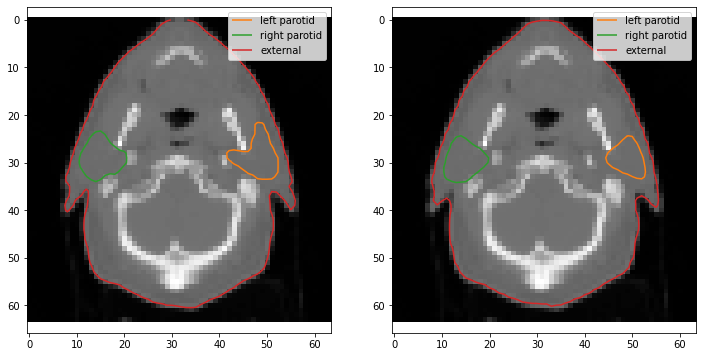


Sample Prediction after epoch 45

Epoch 46/50
4/4 [==============================] - 1s 251ms/step - loss: 0.0166 - binary_accuracy: 0.9807 - recall: 0.9287 - precision: 0.9932 - val_loss: 0.0177 - val_binary_accuracy: 0.9810 - val_recall: 0.9209 - val_precision: 0.9955


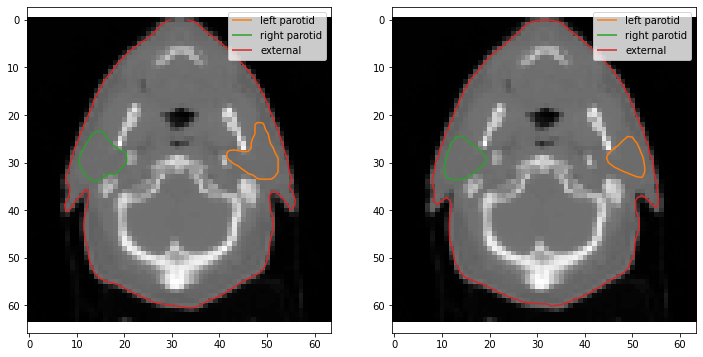


Sample Prediction after epoch 46

Epoch 47/50
4/4 [==============================] - 1s 251ms/step - loss: 0.0165 - binary_accuracy: 0.9807 - recall: 0.9278 - precision: 0.9935 - val_loss: 0.0172 - val_binary_accuracy: 0.9810 - val_recall: 0.9288 - val_precision: 0.9923


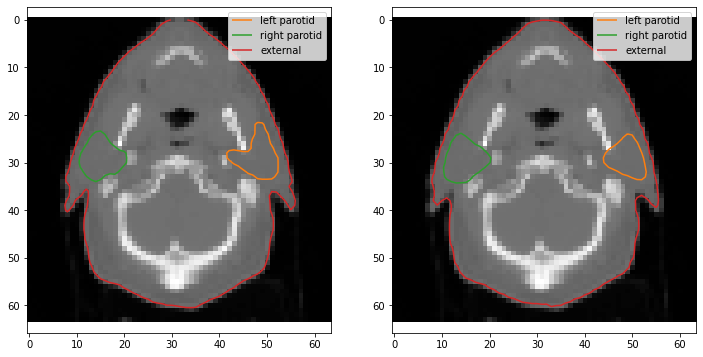


Sample Prediction after epoch 47

Epoch 48/50
4/4 [==============================] - 1s 245ms/step - loss: 0.0163 - binary_accuracy: 0.9808 - recall: 0.9286 - precision: 0.9934 - val_loss: 0.0171 - val_binary_accuracy: 0.9810 - val_recall: 0.9319 - val_precision: 0.9912


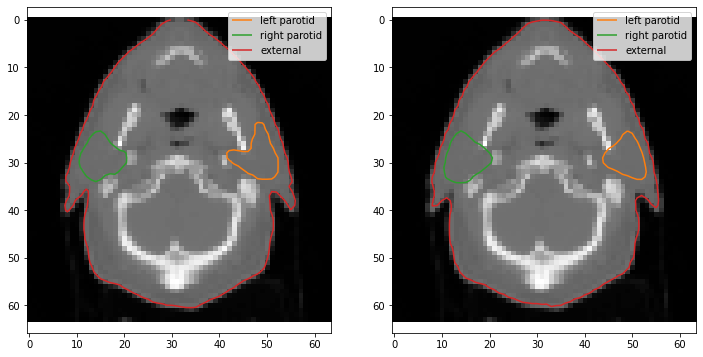


Sample Prediction after epoch 48

Epoch 49/50
4/4 [==============================] - 1s 251ms/step - loss: 0.0163 - binary_accuracy: 0.9808 - recall: 0.9292 - precision: 0.9932 - val_loss: 0.0176 - val_binary_accuracy: 0.9810 - val_recall: 0.9221 - val_precision: 0.9958


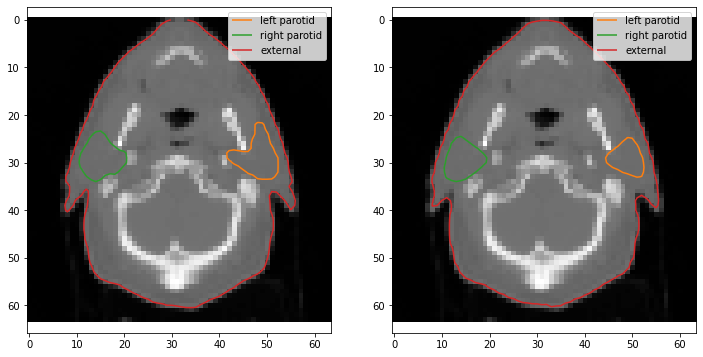


Sample Prediction after epoch 49

Epoch 50/50
4/4 [==============================] - 1s 250ms/step - loss: 0.0162 - binary_accuracy: 0.9808 - recall: 0.9283 - precision: 0.9938 - val_loss: 0.0170 - val_binary_accuracy: 0.9810 - val_recall: 0.9323 - val_precision: 0.9911


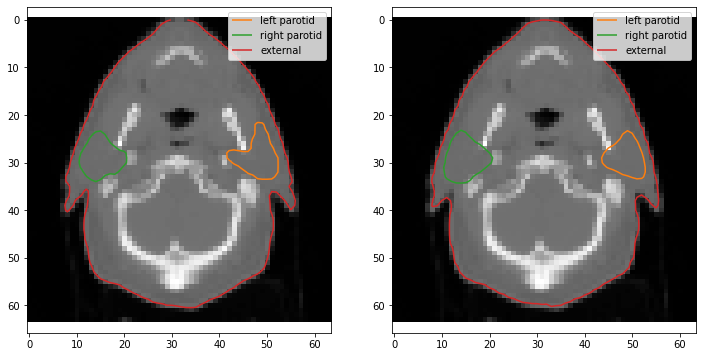


Sample Prediction after epoch 50



In [ ]:
history = model.fit(
    batched_training_dataset,
    epochs=50,
    validation_data=batched_validation_dataset,
    callbacks=[DisplayCallback()],
)

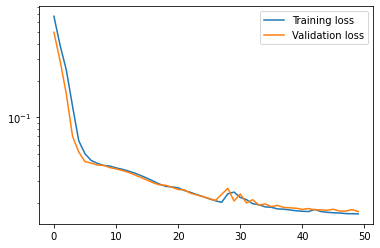

In [38]:
plt.semilogy(history.history['loss'], label="Training loss")
plt.semilogy(history.history['val_loss'], label="Validation loss")
plt.legend()